# College Selection using DEA → ANP (Synthetic Example)

This notebook shows a complete, **runnable** example of how a 12th-pass student
can use a **two-stage analytics pipeline** to choose an engineering college:

1. **Stage 1 – DEA (Data Envelopment Analysis)**  
   - Compare **30 synthetic colleges** on measurable inputs & outputs.  
   - Use **input-oriented CCR DEA** to compute an efficiency score for each college.  
   - Shortlist the **top 7** colleges.

2. **Stage 2 – ANP (Analytic Network Process)**  
   - On the shortlisted 7 colleges, consider **personal and qualitative criteria** such as:  
     distance from home, hostel availability, branch availability, financial factors,
     campus life and reputation.  
   - Use a simplified **ANP-style supermatrix** to compute final priorities and visualize
     the best choices.

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import linprog

In [55]:
# Plot settings

plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = 'lightgray'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 6
plt.rcParams['figure.edgecolor'] = 'black'
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['figure.dpi'] = 120

In [56]:
np.random.seed(123)  # Reproducibility

### Utility Functions definition

In [57]:
def principal_eigenvector(matrix):
    """
    Compute the principal eigenvector of a positive matrix
    and normalize it to sum to 1.
    """
    vals, vecs = np.linalg.eig(matrix)
    idx = np.argmax(vals.real)
    v = np.abs(vecs[:, idx].real)
    return v / v.sum()

In [58]:
def scores_to_pcm(scores, reverse=False):
    """
    Build a pairwise comparison matrix from a vector of scores.
    - If reverse is False: higher score = more preferred.
    - If reverse is True: lower score = more preferred.
    """
    n = len(scores)
    pcm = np.ones((n, n))
    for i in range(n):
        for j in range(n):
            if reverse:
                # lower is better
                val = scores[j] / scores[i]
            else:
                val = scores[i] / scores[j]
            pcm[i, j] = val
    return pcm

## Stage 1 – DEA: Screening 30 Engineering Colleges

**Goal:** Rank many colleges on *efficiency* using objective, measurable criteria.

Each **college** is a **DMU (Decision Making Unit)**.  
We define **inputs** (resources the college uses) and **outputs** (results it produces).

### Inputs (resources – want to minimize for given outputs)
1. `Faculty_FTE` – Number of full-time equivalent faculty members.
 
2. `PhD_Faculty_Count` – Number of PhD-qualified faculty members.  

3. `Total_Beds_in_hostel` – Total hostel beds (proxy for residential infrastructure).  

4. `Infrastructure_Score` – 0–100 index for labs, library, workshops, etc.  

5. `Operating_Expenditure_Lakh` – Annual operating expenditure (in INR lakhs).

### Outputs (performance – want to maximize)
1. `Placement_Rate` – % of eligible students placed (0–100).  

2. `Average_Package_LPA` – Average package of placed students (in LPA).  

3. `Research_Publications` – Number of peer-reviewed publications last year.  

4. `Student_Satisfaction` – 0–100 student feedback index.  

5. `Graduation_Rate` – % of students graduating on time.


In [59]:
# Generate synthetic DEA data

num_colleges = 30
colleges = [f"C{i+1}" for i in range(num_colleges)]

# We create size categories: large, medium, small
sizes = np.random.choice(["large", "medium", "small"], size=num_colleges, p=[0.3, 0.4, 0.3])

Faculty_FTE = []
PhD_Faculty_Count = []
Total_Beds_in_hostel = []
Infrastructure_Score = []
Operating_Expenditure_Lakh = []

Placement_Rate = []
Average_Package_LPA = []
Research_Publications = []
Student_Satisfaction = []
Graduation_Rate = []

for sz in sizes:
    if sz == "large":
        fac = np.random.randint(100, 180)        # more faculty
        phd = np.random.randint(int(fac*0.2), int(fac*0.5))
        beds = np.random.randint(800, 2000)
        infra = np.random.randint(75, 90)
        op_cost = np.random.randint(1000, 2000)  # lakh
        
        placement = np.random.normal(85, 5)
        avg_pkg = np.random.normal(7.0, 1.0)
        pubs = int(np.random.normal(40, 15))
        sat = np.random.normal(82, 5)
        grad = np.random.normal(92, 3)
    elif sz == "medium":
        fac = np.random.randint(60, 110)
        phd = np.random.randint(int(fac*0.15), int(fac*0.4))
        beds = np.random.randint(400, 1200)
        infra = np.random.randint(65, 82)
        op_cost = np.random.randint(600, 1200)
        
        placement = np.random.normal(78, 6)
        avg_pkg = np.random.normal(5.5, 0.8)
        pubs = int(np.random.normal(20, 8))
        sat = np.random.normal(78, 6)
        grad = np.random.normal(88, 4)
    else:  # small
        fac = np.random.randint(30, 70)
        phd = np.random.randint(int(fac*0.1), int(fac*0.3))
        beds = np.random.randint(0, 800)
        infra = np.random.randint(55, 72)
        op_cost = np.random.randint(300, 800)
        
        placement = np.random.normal(70, 7)
        avg_pkg = np.random.normal(4.0, 0.7)
        pubs = int(np.random.normal(8, 4))
        sat = np.random.normal(73, 7)
        grad = np.random.normal(82, 5)

    # Clip to reasonable ranges
    placement = float(np.clip(placement, 40, 99))
    avg_pkg = float(np.clip(avg_pkg, 2.0, 12.0))
    pubs = max(pubs, 0)
    sat = float(np.clip(sat, 40, 95))
    grad = float(np.clip(grad, 60, 99))

    Faculty_FTE.append(fac)
    PhD_Faculty_Count.append(phd)
    Total_Beds_in_hostel.append(beds)
    Infrastructure_Score.append(infra)
    Operating_Expenditure_Lakh.append(op_cost)

    Placement_Rate.append(placement)
    Average_Package_LPA.append(avg_pkg)
    Research_Publications.append(pubs)
    Student_Satisfaction.append(sat)
    Graduation_Rate.append(grad)
    
    College_Cutoff_Rank = np.random.randint(500, 50000, size=num_colleges)

dea_df = pd.DataFrame({
    "College": colleges,
    "Size_Category": sizes,
    "Faculty_FTE": Faculty_FTE,
    "PhD_Faculty_Count": PhD_Faculty_Count,
    "Total_Beds_in_hostel": Total_Beds_in_hostel,
    "Infrastructure_Score": Infrastructure_Score,
    "Operating_Expenditure_Lakh": Operating_Expenditure_Lakh,
    "Placement_Rate": Placement_Rate,
    "Average_Package_LPA": Average_Package_LPA,
    "Research_Publications": Research_Publications,
    "Student_Satisfaction": Student_Satisfaction,
    "Graduation_Rate": Graduation_Rate,
    "College_Cutoff_Rank": College_Cutoff_Rank
})

dea_df.head()


,College,Size_Category,Faculty_FTE,PhD_Faculty_Count,Total_Beds_in_hostel,Infrastructure_Score,Operating_Expenditure_Lakh,Placement_Rate,Average_Package_LPA,Research_Publications,Student_Satisfaction,Graduation_Rate,College_Cutoff_Rank
0,C1,medium,102,20,976,76,1018,76.038323,5.253433,26,84.424689,75.777690,8494
1,C2,large,103,31,1555,83,1222,90.029660,6.227291,51,83.571360,88.021204,48686
2,C3,large,151,37,1798,83,1966,91.276187,6.311131,64,86.036541,91.055726,23556
3,C4,medium,84,26,615,70,1162,71.484586,5.684542,24,81.403473,79.675958,45933
4,C5,small,39,5,673,60,424,75.686389,4.349818,9,69.052532,77.013393,48017


### DEA model: Input-Oriented CCR

In [60]:
def dea_input_oriented_ccr(inputs, outputs):
    """
    Compute input-oriented CCR DEA efficiency scores for each DMU.
    inputs:  (n_dmu, n_inputs)
    outputs: (n_dmu, n_outputs)
    Returns: scores (theta) of length n_dmu
    """
    num_dmu = inputs.shape[0]
    num_inputs = inputs.shape[1]
    num_outputs = outputs.shape[1]
    
    scores = np.zeros(num_dmu)
    
    for d in range(num_dmu):
        x0 = inputs[d, :]
        y0 = outputs[d, :]
        
        # Variables: [theta, lambda_1, ..., lambda_n]
        c = np.zeros(1 + num_dmu)
        c[0] = 1.0  # minimize theta
        
        A_ub = []
        b_ub = []
        
        # Input constraints: sum_j lambda_j * x_ij - theta * x_i0 <= 0
        for i_in in range(num_inputs):
            row = np.zeros(1 + num_dmu)
            row[0] = -x0[i_in]
            row[1:] = inputs[:, i_in]
            A_ub.append(row)
            b_ub.append(0.0)
        
        # Output constraints: -sum_j lambda_j * y_rj <= -y0_r (i.e., sum_j lambda_j * y_rj >= y0_r)
        for r_out in range(num_outputs):
            row = np.zeros(1 + num_dmu)
            row[1:] = -outputs[:, r_out]
            A_ub.append(row)
            b_ub.append(-y0[r_out])
        
        A_ub = np.array(A_ub)
        b_ub = np.array(b_ub)
        
        # Bounds: 0 <= theta <= 1, lambda_j >= 0
        bounds = [(0, 1)] + [(0, None)] * num_dmu
        
        res = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method="highs")
        if res.success:
            scores[d] = res.x[0]
        else:
            scores[d] = np.nan
    
    return scores

In [61]:
# Prepare input and output matrices
input_cols = ["Faculty_FTE", "PhD_Faculty_Count", "Total_Beds_in_hostel",
              "Infrastructure_Score", "Operating_Expenditure_Lakh"]
output_cols = ["Placement_Rate", "Average_Package_LPA", "Research_Publications",
               "Student_Satisfaction", "Graduation_Rate", "College_Cutoff_Rank"]

In [62]:
# Reverse the cutoff rank because DEA maximizes outputs
dea_df["Inv_College_Cutoff"] = dea_df["College_Cutoff_Rank"].max() - dea_df["College_Cutoff_Rank"]

# Replace in DEA outputs
output_cols[-1] = "Inv_College_Cutoff"

In [63]:
inputs = dea_df[input_cols].values.astype(float)
outputs = dea_df[output_cols].values.astype(float)

dea_scores = dea_input_oriented_ccr(inputs, outputs)
dea_df["DEA_Efficiency_Theta"] = dea_scores

dea_df_sorted = dea_df.sort_values("DEA_Efficiency_Theta", ascending=False)  # closer to 1 is better
dea_df_sorted.head(10)

,College,Size_Category,Faculty_FTE,PhD_Faculty_Count,Total_Beds_in_hostel,Infrastructure_Score,Operating_Expenditure_Lakh,Placement_Rate,Average_Package_LPA,Research_Publications,Student_Satisfaction,Graduation_Rate,College_Cutoff_Rank,Inv_College_Cutoff,DEA_Efficiency_Theta
23,C24,medium,76,27,901,75,801,76.896883,4.652001,26,82.527309,80.343115,16167,32946,1.0
13,C14,large,141,51,1149,84,1836,85.451310,6.780610,48,81.219143,86.207736,26611,22502,1.0
28,C29,large,157,47,1754,82,1622,85.248786,7.230669,52,83.330264,92.610901,24047,25066,1.0
27,C28,large,109,45,1745,89,1517,87.677952,7.377828,52,87.849691,95.916830,27598,21515,1.0
9,C10,medium,106,17,1155,73,1096,75.886259,3.930490,27,84.672075,82.733079,35453,13660,1.0
8,C9,medium,96,34,489,70,713,93.814112,4.405439,5,74.676704,92.476017,16235,32878,1.0
1,C2,large,103,31,1555,83,1222,90.029660,6.227291,51,83.571360,88.021204,48686,427,1.0
20,C21,medium,60,23,1042,74,987,66.152312,6.161063,11,75.518825,85.509341,3875,45238,1.0
10,C11,medium,107,36,579,74,1184,74.693352,6.336308,10,68.382696,85.273985,41237,7876,1.0
12,C13,medium,107,22,522,73,1085,71.751857,5.341557,30,74.392511,87.355821,4425,44688,1.0


### DEA plot and shortlist

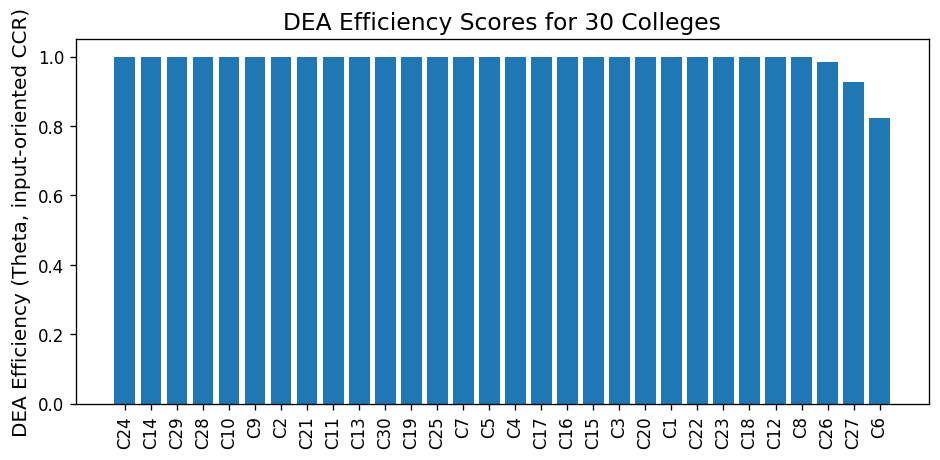

,College,Size_Category,Faculty_FTE,PhD_Faculty_Count,Total_Beds_in_hostel,Infrastructure_Score,Operating_Expenditure_Lakh,Placement_Rate,Average_Package_LPA,Research_Publications,Student_Satisfaction,Graduation_Rate,College_Cutoff_Rank,Inv_College_Cutoff,DEA_Efficiency_Theta
0,C24,medium,76,27,901,75,801,76.896883,4.652001,26,82.527309,80.343115,16167,32946,1.0
1,C14,large,141,51,1149,84,1836,85.451310,6.780610,48,81.219143,86.207736,26611,22502,1.0
2,C29,large,157,47,1754,82,1622,85.248786,7.230669,52,83.330264,92.610901,24047,25066,1.0
3,C28,large,109,45,1745,89,1517,87.677952,7.377828,52,87.849691,95.916830,27598,21515,1.0
4,C10,medium,106,17,1155,73,1096,75.886259,3.930490,27,84.672075,82.733079,35453,13660,1.0
5,C9,medium,96,34,489,70,713,93.814112,4.405439,5,74.676704,92.476017,16235,32878,1.0
6,C2,large,103,31,1555,83,1222,90.029660,6.227291,51,83.571360,88.021204,48686,427,1.0


In [64]:
# Visualize DEA efficiency scores
plt.figure()
plt.bar(dea_df_sorted["College"], dea_df_sorted["DEA_Efficiency_Theta"])
plt.xticks(rotation=90)
plt.ylabel("DEA Efficiency (Theta, input-oriented CCR)")
plt.title("DEA Efficiency Scores for 30 Colleges")
plt.tight_layout()
plt.show()

# Shortlist top 7 colleges
shortlist_size = 7
shortlisted = dea_df_sorted.head(shortlist_size).copy()
shortlisted.reset_index(drop=True, inplace=True)
shortlisted

<center>
    The table above shows the top 7 colleges after DEA.
</center>

## Stage 2 – ANP: Choosing among the 7 Shortlisted Colleges

Now we take the shortlisted colleges and consider **personal and qualitative criteria**.

### ANP Criteria and Clusters

We group criteria into **5 clusters**:

1. **Logistics (L)**  
   - `Distance_from_Home_km` (lower better)  
   
   - `Travel_Time_min` (lower better)  
   
   - `Hostel_Availability` (higher better, coded 0, 0.5, 1)

2. **Academic Fit (A)**  
   - `Branch_Offered` (1 if your branch is available; here we assume all 1 for demo)  
   
   - `Faculty_Student_Ratio` (higher better)  
   
   - `Curriculum_Relevance` (0–100; higher better)

3. **Financial (F)**  
   - `Total_Fee_per_year` (lower better)  
   
   - `Scholarship_Availability` (0–100; higher better)  
   
   - `Fee_Flexibility` (0 or 1; higher better)

4. **Campus Life & Safety (C)**  
   - `Campus_Safety_Index` (0–100; higher better)  
   
   - `Extracurriculars` (0–100; higher better)  
   
   - `Locality_Health_Facilities` (0–100; higher better)

5. **Reputation & Outcomes (R)**  
   - `Alumni_Network_Strength` (0–100; higher better)  
   
   - `Industry_Ties` (0–100; higher better)  
   
   - `Special_Accreditations` (0–100; higher better)

In [65]:
# Add Student's rank for the examination

student_rank = 4312

In [66]:
shortlisted_cols = shortlisted["College"].tolist()
n_alt = len(shortlisted_cols)

# Synthetic ANP data for shortlisted colleges

# Distance: some close, some far (km)
Distance_from_Home_km = np.random.randint(5, 600, size=n_alt)

# Travel time (minutes): roughly distance / speed + noise (assume 40-60 km/h)
Travel_Time_min = (Distance_from_Home_km / np.random.uniform(40, 60, size=n_alt)) * 60
Travel_Time_min = Travel_Time_min.astype(int)

# Hostel availability based on distance and size: if far, more likely good hostel
Hostel_Availability = []
for i, d in enumerate(Distance_from_Home_km):
    if d <= 30:
        # Close; hostel might be limited or optional
        Hostel_Availability.append(np.random.choice([0, 0.5, 1], p=[0.3, 0.5, 0.2]))
    elif d <= 200:
        Hostel_Availability.append(np.random.choice([0.5, 1], p=[0.4, 0.6]))
    else:
        Hostel_Availability.append(1.0)

Hostel_Availability = np.array(Hostel_Availability)

# Academic Fit
Rank_Fit_Score = np.clip(
    1 - (student_rank / shortlisted["College_Cutoff_Rank"].values),
    0, 1
)   # Higher "Rank_Fit_Score" = better match
Branch_Offered = np.ones(n_alt)  # assume all shortlisted colleges offer your desired branch

# approximate student count from size category
size_map = {"large": 900, "medium": 600, "small": 350}

students = np.array([size_map[sz] for sz in shortlisted["Size_Category"]])

Faculty_Student_Ratio = shortlisted["Faculty_FTE"].values / students

Curriculum_Relevance = np.clip(
    np.random.normal(75, 8, size=n_alt) + (shortlisted["Student_Satisfaction"].values - 80) * 0.2,
    50, 95
)

# Financial
Total_Fee_per_year = np.random.randint(80, 260, size=n_alt) * 10000  # INR
Scholarship_Availability = np.clip(
    np.random.normal(60, 15, size=n_alt) + (shortlisted["Placement_Rate"].values - 80) * 0.3,
    20, 95
)

Fee_Flexibility = np.random.choice([0, 1], size=n_alt, p=[0.3, 0.7])

# Campus Life & Safety – correlated with satisfaction
Campus_Safety_Index = np.clip(
    np.random.normal(80, 7, size=n_alt) + (shortlisted["Student_Satisfaction"].values - 80) * 0.2,
    50, 99
)

Extracurriculars = np.clip(
    np.random.normal(78, 10, size=n_alt) + (shortlisted["Student_Satisfaction"].values - 80) * 0.3,
    40, 99
)

Locality_Health_Facilities = np.clip(
    np.random.normal(75, 8, size=n_alt),
    40, 95
)

# Reputation & Outcomes – correlated with placement and research
Alumni_Network_Strength = np.clip(
    np.random.normal(75, 10, size=n_alt) + (shortlisted["Placement_Rate"].values - 80) * 0.4,
    40, 99
)

Industry_Ties = np.clip(
    np.random.normal(78, 8, size=n_alt) + shortlisted["Average_Package_LPA"].values * 1.0,
    40, 99
)

Special_Accreditations = np.clip(
    np.random.normal(80, 5, size=n_alt),
    60, 99
)

anp_df = pd.DataFrame({
    "Rank_Fit_Score": Rank_Fit_Score,
    "College": shortlisted_cols,
    "Distance_from_Home_km": Distance_from_Home_km,
    "Travel_Time_min": Travel_Time_min,
    "Hostel_Availability": Hostel_Availability,
    "Branch_Offered": Branch_Offered,
    "Faculty_Student_Ratio": Faculty_Student_Ratio,
    "Curriculum_Relevance": Curriculum_Relevance,
    "Total_Fee_per_year": Total_Fee_per_year,
    "Scholarship_Availability": Scholarship_Availability,
    "Fee_Flexibility": Fee_Flexibility,
    "Campus_Safety_Index": Campus_Safety_Index,
    "Extracurriculars": Extracurriculars,
    "Locality_Health_Facilities": Locality_Health_Facilities,
    "Alumni_Network_Strength": Alumni_Network_Strength,
    "Industry_Ties": Industry_Ties,
    "Special_Accreditations": Special_Accreditations
})

anp_df

,Rank_Fit_Score,College,Distance_from_Home_km,Travel_Time_min,Hostel_Availability,Branch_Offered,Faculty_Student_Ratio,Curriculum_Relevance,Total_Fee_per_year,Scholarship_Availability,Fee_Flexibility,Campus_Safety_Index,Extracurriculars,Locality_Health_Facilities,Alumni_Network_Strength,Industry_Ties,Special_Accreditations
0,0.733284,C24,61,70,0.5,1.0,0.126667,63.017218,1000000,42.654964,1,67.405025,90.760443,89.133887,72.075941,95.802011,81.503183
1,0.837962,C14,193,244,0.5,1.0,0.156667,59.839133,2180000,62.757124,1,84.053620,93.534317,70.755893,69.168653,88.706784,86.625748
2,0.820684,C29,272,392,1.0,1.0,0.174444,53.310275,1070000,83.411782,1,87.896274,90.815130,77.751645,62.746022,63.639110,77.524427
3,0.843757,C28,330,467,1.0,1.0,0.121111,68.257103,2360000,88.794016,1,87.692089,78.241746,77.279251,82.753054,65.007774,68.857605
4,0.878374,C10,175,181,0.5,1.0,0.176667,58.579151,1600000,76.182704,1,75.969288,79.676321,68.886906,60.805905,91.198931,74.917007
5,0.734401,C9,156,190,0.5,1.0,0.160000,73.650497,1920000,34.420177,1,77.929249,69.878940,54.250452,81.982019,86.858382,83.128673
6,0.911432,C2,105,105,1.0,1.0,0.114444,57.822933,2070000,45.473925,0,81.820945,73.048556,69.342538,80.816976,86.490352,79.476205


### Building Cluster Scores

For each cluster, we compress the multiple indicators into a **single score per college**

- LogisticsScore: combination of distance (lower better), travel time (lower better),
  and hostel availability (higher better).

- AcademicScore: combination of Student's rank, branch (binary, here always 1), faculty-student ratio (higher better), and curriculum relevance.

- FinancialScore: combination of fee (lower better), scholarships, and fee flexibility.

- CampusScore: safety, extracurriculars, health facilities.

- ReputationScore: alumni network, industry ties, accreditations.

In [67]:
# Normalize helpers
def normalize_positive(x):
    x = np.array(x, dtype=float)
    return (x - x.min()) / (x.max() - x.min() + 1e-9)

def normalize_negative(x):
    # for "lower is better" criteria
    x = np.array(x, dtype=float)
    return (x.max() - x) / (x.max() - x.min() + 1e-9)

# Cluster scores
logistics_score = (
    0.4 * normalize_negative(anp_df["Distance_from_Home_km"]) +
    0.3 * normalize_negative(anp_df["Travel_Time_min"]) +
    0.3 * normalize_positive(anp_df["Hostel_Availability"])
)

academic_score = (
    0.2 * normalize_positive(anp_df["Branch_Offered"]) +
    0.4 * normalize_positive(anp_df["Faculty_Student_Ratio"]) +
    0.4 * normalize_positive(anp_df["Curriculum_Relevance"]) +
    0.20 * normalize_positive(anp_df["Rank_Fit_Score"])
)

financial_score = (
    0.4 * normalize_negative(anp_df["Total_Fee_per_year"]) +
    0.4 * normalize_positive(anp_df["Scholarship_Availability"]) +
    0.2 * normalize_positive(anp_df["Fee_Flexibility"])
)

campus_score = (
    0.4 * normalize_positive(anp_df["Campus_Safety_Index"]) +
    0.3 * normalize_positive(anp_df["Extracurriculars"]) +
    0.3 * normalize_positive(anp_df["Locality_Health_Facilities"])
)

reputation_score = (
    0.4 * normalize_positive(anp_df["Alumni_Network_Strength"]) +
    0.3 * normalize_positive(anp_df["Industry_Ties"]) +
    0.3 * normalize_positive(anp_df["Special_Accreditations"])
)

cluster_scores = pd.DataFrame({
    "College": anp_df["College"],
    "LogisticsScore": logistics_score,
    "AcademicScore": academic_score,
    "FinancialScore": financial_score,
    "CampusScore": campus_score,
    "ReputationScore": reputation_score
})
cluster_scores

,College,LogisticsScore,AcademicScore,FinancialScore,CampusScore,ReputationScore
0,C24,0.700000,0.269463,0.660579,0.564821,0.718913
1,C14,0.372231,0.517339,0.461401,0.766937,0.686235
2,C29,0.442920,0.483835,0.939817,0.867627,0.181692
3,C28,0.300000,0.460817,0.600000,0.700121,0.412766
4,C10,0.446604,0.666502,0.730755,0.417305,0.359373
5,C9,0.468056,0.694111,0.329412,0.205438,0.843480
6,C2,0.908124,0.288744,0.166611,0.451397,0.757145


In [68]:
clusters = ["Logistics", "Academic", "Financial", "Campus", "Reputation"]
n_clusters = len(clusters)
n_alt = len(anp_df)

# Local alternative priority vectors per cluster
local_weights = {}

for cl, scores in zip(clusters,
                      [cluster_scores["LogisticsScore"],
                       cluster_scores["AcademicScore"],
                       cluster_scores["FinancialScore"],
                       cluster_scores["CampusScore"],
                       cluster_scores["ReputationScore"]]):
    pcm = scores_to_pcm(scores.values, reverse=False)  # higher score = better
    w = principal_eigenvector(pcm)
    local_weights[cl] = w

local_df = pd.DataFrame(local_weights, index=anp_df["College"])
local_df

,Logistics,Academic,Financial,Campus,Reputation
College,,,,,
C24,0.192417,0.079704,0.169877,0.142142,0.181562
C14,0.102319,0.153022,0.118656,0.193006,0.173309
C29,0.121750,0.143112,0.241687,0.218345,0.045886
C28,0.082464,0.136304,0.154298,0.176191,0.104244
C10,0.122763,0.197143,0.187923,0.105018,0.090760
C9,0.128660,0.205309,0.084713,0.051700,0.213021
C2,0.249626,0.085407,0.042846,0.113598,0.191217


In [69]:
# Inter-cluster influence (5x5)
# We encode subjective belief: Academic and Reputation are strongest,
# then Financial, then Logistics and Campus.
cluster_pcm = np.array([
    [1,   1/3, 1/2, 1/2, 1/4],  # Logistics
    [3,   1,   2,   2,   1/2],  # Academic
    [2,   1/2, 1,   1,   1/3],  # Financial
    [2,   1/2, 1,   1,   1/3],  # Campus
    [4,   2,   3,   3,   1  ]   # Reputation
], dtype=float)

cluster_priorities = principal_eigenvector(cluster_pcm)
cluster_priorities_series = pd.Series(cluster_priorities, index=clusters)
cluster_priorities_series

Logistics     0.079086
Academic      0.244403
Financial     0.136732
Campus        0.136732
Reputation    0.403048
dtype: float64

In [70]:
# Build the (n_alt * n_clusters) x (n_alt * n_clusters) supermatrix
N = n_alt * n_clusters
supermatrix = np.zeros((N, N))

def idx(cluster_index, alt_index):
    return cluster_index * n_alt + alt_index

# For simplicity, we assume each cluster j influences each cluster i
# proportionally to cluster_priorities[j].
for i_cl in range(n_clusters):     # receiving cluster
    for j_cl in range(n_clusters): # influencing cluster
        influence = cluster_priorities[j_cl]
        # Alternatives in cluster i receive weights according to their local priorities in cluster i
        w_i = local_df[clusters[i_cl]].values.reshape(-1, 1)  # column vector (n_alt x 1)
        block = w_i * influence  # each column for that cluster j has same distribution
        r_start = i_cl * n_alt
        c_start = j_cl * n_alt
        supermatrix[r_start:r_start+n_alt, c_start:c_start+n_alt] = block

# Column normalize
col_sums = supermatrix.sum(axis=0)
col_sums[col_sums == 0] = 1.0
W = supermatrix / col_sums

# Compute limit matrix
limit = W.copy()
for _ in range(150):
    limit = limit @ W

# Aggregate final priorities for each alternative across clusters
# Each alternative appears in n_clusters positions (one per cluster).
final_priorities_raw = np.zeros(n_alt)
for a in range(n_alt):
    # row indices for alt 'a' across all clusters
    rows = [idx(c, a) for c in range(n_clusters)]
    final_priorities_raw[a] = limit[rows, :].sum()

final_priorities = final_priorities_raw / final_priorities_raw.sum()

anp_results = pd.DataFrame({
    "College": anp_df["College"],
    "ANP_Priority": final_priorities
}).sort_values("ANP_Priority", ascending=False).reset_index(drop=True)

anp_results

,College,ANP_Priority
0,C29,0.154156
1,C24,0.153140
2,C14,0.148062
3,C10,0.140721
4,C9,0.136681
5,C2,0.136539
6,C28,0.130700


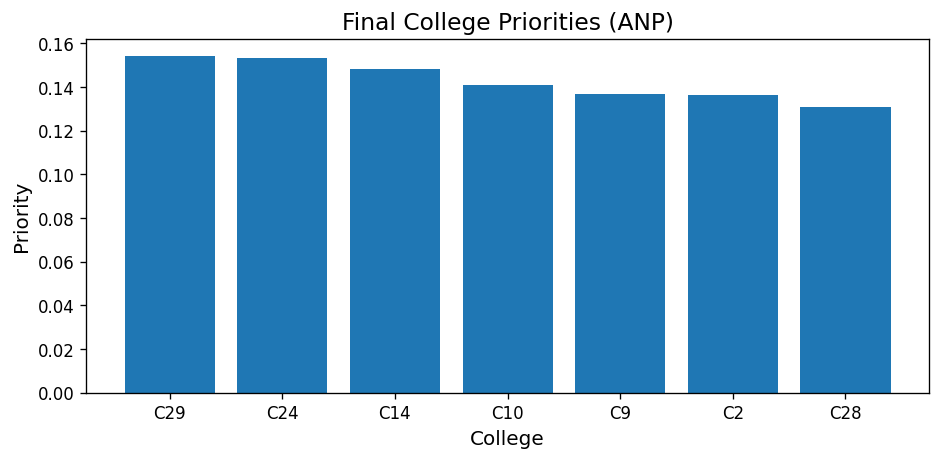

In [71]:
plt.figure()
plt.bar(anp_results["College"], anp_results["ANP_Priority"])
plt.title("Final College Priorities (ANP)")
plt.ylabel("Priority")
plt.xlabel("College")
plt.tight_layout()
plt.show()